In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import OmicsIntegrator as oi
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import network_utils as nu

In [2]:
# Reload modules in case of modifications
reload(nu)

<module 'network_utils' from '/home/louiscam/projects/gpcr/code/analysis_mar10/network_utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'

# Adhesome components

In [4]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


In [5]:
# List of intrinsic components
intrinsic_comps = np.sort(df_components[df_components['FA']=='Intrinsic Proteins']['Official Symbol'].values)
# List of associated components
associated_comps = np.sort(df_components[df_components['FA']=='Associated Proteins']['Official Symbol'].values)

# Adhesome interactions

In [6]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
print('Number of interactions: '+str(len(df_interactions)))
df_interactions.head()

Number of interactions: 6542


,Source,Target,Effect,Type,PMID,data_source
0,LPXN,GIT1,0,Binding,12674328,adhesome.org
1,GIT1,ARF1,_,Inhibition,10896954,adhesome.org
2,ARPC2,CTTN,0,Binding,11018051,adhesome.org
3,INSR,PTPN6,+,Activation,7512963,adhesome.org
4,ACTB,TLN1,0,Binding,2121138,adhesome.org


### Preprocess

In [7]:
# Add vertices as set
df_interactions['vertices'] = [str(sorted(np.array([df_interactions.iloc[i]['Source'],
                                    df_interactions.iloc[i]['Target']])))
                               for i in range(len(df_interactions))]
df_interactions.head()

,Source,Target,Effect,Type,PMID,data_source,vertices
0,LPXN,GIT1,0,Binding,12674328,adhesome.org,"['GIT1', 'LPXN']"
1,GIT1,ARF1,_,Inhibition,10896954,adhesome.org,"['ARF1', 'GIT1']"
2,ARPC2,CTTN,0,Binding,11018051,adhesome.org,"['ARPC2', 'CTTN']"
3,INSR,PTPN6,+,Activation,7512963,adhesome.org,"['INSR', 'PTPN6']"
4,ACTB,TLN1,0,Binding,2121138,adhesome.org,"['ACTB', 'TLN1']"


In [8]:
# Harmonize types
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')
# Add TypeID
typeid = {'activation':1, 'binding':0, 'colocalization':0, 'compound':0,
       'dephosphorylation':0, 'direct_interaction':0, 'enzymatic':0, 'gef':0,
       'inhibition':2, 'phosphorylation':0, 'unknown':0}
df_interactions['TypeID'] = [typeid[df_interactions.iloc[i]['Type']] for i in range(len(df_interactions))]
df_interactions.head()

,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID
0,LPXN,GIT1,0,binding,12674328,adhesome.org,"['GIT1', 'LPXN']",0
1,GIT1,ARF1,_,inhibition,10896954,adhesome.org,"['ARF1', 'GIT1']",2
2,ARPC2,CTTN,0,binding,11018051,adhesome.org,"['ARPC2', 'CTTN']",0
3,INSR,PTPN6,+,activation,7512963,adhesome.org,"['INSR', 'PTPN6']",1
4,ACTB,TLN1,0,binding,2121138,adhesome.org,"['ACTB', 'TLN1']",0


In [9]:
# Add field for visualization
df_interactions['show'] = df_interactions['Type'].isin(['activation','inhibition'])
df_interactions.head()

,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
0,LPXN,GIT1,0,binding,12674328,adhesome.org,"['GIT1', 'LPXN']",0,False
1,GIT1,ARF1,_,inhibition,10896954,adhesome.org,"['ARF1', 'GIT1']",2,True
2,ARPC2,CTTN,0,binding,11018051,adhesome.org,"['ARPC2', 'CTTN']",0,False
3,INSR,PTPN6,+,activation,7512963,adhesome.org,"['INSR', 'PTPN6']",1,True
4,ACTB,TLN1,0,binding,2121138,adhesome.org,"['ACTB', 'TLN1']",0,False


In [10]:
# Remove duplicates based on Source, Target, Type
df_interactions = df_interactions.sort_values(by='data_source')
df_interactions = df_interactions.drop_duplicates(subset=['Source','Target','Type'], keep='first')
print('Number of interactions: '+str(len(df_interactions)))
df_interactions.head()

Number of interactions: 3470


,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
0,LPXN,GIT1,0,binding,12674328,adhesome.org,"['GIT1', 'LPXN']",0,False
918,CSK,IRS1,+,activation,8756634,adhesome.org,"['CSK', 'IRS1']",1,True
917,ACTN1,PTPN1,_,inhibition,16291744,adhesome.org,"['ACTN1', 'PTPN1']",2,True
916,SRC,ITGB1,+,activation,11723131,adhesome.org,"['ITGB1', 'SRC']",1,True
915,PTK2B,PTPN11,_,inhibition,10880513,adhesome.org,"['PTK2B', 'PTPN11']",2,True


In [11]:
# Number of directed edges in the graph
len(df_interactions[df_interactions['Type']!='binding'].drop_duplicates(subset=['Source','Target']))

705

In [12]:
# Number of undirected edges in the graph
len(df_interactions[df_interactions['Type']=='binding'].drop_duplicates(subset=['Source','Target']))

2670

In [13]:
# Number of undirected edges in the graph
len(np.unique(df_interactions['vertices']))

1501

### Identify directed edges with contradictory annotation 

In [14]:
# Copy interaction dataframe
df_interactions1 = df_interactions.copy()

In [15]:
# Select only directed edges (all except binding type)
df_interactions1 = df_interactions1[~(df_interactions1['Type']=='binding')]
print('Number of directed edges = '+str(len(df_interactions1)))
df_interactions1.head()

Number of directed edges = 800


,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
918,CSK,IRS1,+,activation,8756634,adhesome.org,"['CSK', 'IRS1']",1,True
917,ACTN1,PTPN1,_,inhibition,16291744,adhesome.org,"['ACTN1', 'PTPN1']",2,True
916,SRC,ITGB1,+,activation,11723131,adhesome.org,"['ITGB1', 'SRC']",1,True
915,PTK2B,PTPN11,_,inhibition,10880513,adhesome.org,"['PTK2B', 'PTPN11']",2,True
914,ARF1,PLD1,+,activation,16054594,adhesome.org,"['ARF1', 'PLD1']",1,True


In [16]:
# Select duplicated interactions
df_duplicated_dir = df_interactions1.loc[df_interactions1.duplicated(subset=['Source','Target'], keep=False)]
df_duplicated_dir = df_duplicated_dir.sort_values(by=['Source','Target','Type'])
print('Number of duplicated edges = '+str(len(df_duplicated_dir)))
df_duplicated_dir.head(6)

Number of duplicated edges = 186


,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
8,ABL1,CBL,+,activation,7925293,adhesome.org,"['ABL1', 'CBL']",1,True
11,ABL1,CBL,_,inhibition,12475393,adhesome.org,"['ABL1', 'CBL']",2,True
130,AKT1,ILK,+,activation,9736715,adhesome.org,"['AKT1', 'ILK']",1,True
3338,AKT1,ILK,0,phosphorylation,10592173,axel_ppi,"['AKT1', 'ILK']",0,False
512,AKT1,PDPK1,+,activation,11752451,adhesome.org,"['AKT1', 'PDPK1']",1,True
5220,AKT1,PDPK1,+,phosphorylation,9094314,axel_ppi,"['AKT1', 'PDPK1']",0,False


Number of duplicates = 87
Number of triplicates = 4


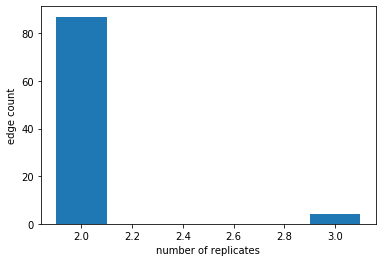

In [17]:
# Check how many times each interaction is duplicated
print('Number of duplicates = '+str(sum(df_duplicated_dir.groupby(['Source','Target']).Type.nunique()==2)))
print('Number of triplicates = '+str(sum(df_duplicated_dir.groupby(['Source','Target']).Type.nunique()==3)))
plt.figure()
plt.bar(x=[2,3], height=list(df_duplicated_dir.groupby(['Source','Target']).Type.nunique().value_counts()), width=0.2)
plt.xlabel('number of replicates')
plt.ylabel('edge count')
plt.show()

### Identify all edges with contradictory annotation 

In [18]:
# Copy interaction dataframe
df_interactions2 = df_interactions.copy()

In [19]:
# Select duplicated interactions
df_duplicated = df_interactions2.loc[df_interactions2.duplicated(subset=['Source','Target'], keep=False)]
df_duplicated = df_duplicated.sort_values(by=['Source','Target','Type'])
print('Number of duplicated edges = '+str(len(df_duplicated)))
df_duplicated.head(6)

Number of duplicated edges = 851


,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
798,ABI1,ABL1,+,activation,12591740,adhesome.org,"['ABI1', 'ABL1']",1,True
2869,ABI1,ABL1,0,binding,18328268,axel_ppi,"['ABI1', 'ABL1']",0,False
1309,ABL1,ABI1,+,activation,12591740,adhesome.org,"['ABI1', 'ABL1']",1,True
1660,ABL1,ABI1,0,binding,12672821,axel_ppi,"['ABI1', 'ABL1']",0,False
498,ABL1,BCAR1,+,activation,7780740,adhesome.org,"['ABL1', 'BCAR1']",1,True
3996,ABL1,BCAR1,0,binding,8810278,axel_ppi,"['ABL1', 'BCAR1']",0,False


Number of duplicates = 302
Number of triplicates = 77
Number of quadruplicates = 4


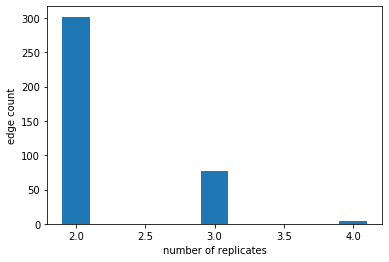

In [20]:
# Check how many times each interaction is duplicated
print('Number of duplicates = '+str(sum(df_duplicated.groupby(['Source','Target']).Type.nunique()==2)))
print('Number of triplicates = '+str(sum(df_duplicated.groupby(['Source','Target']).Type.nunique()==3)))
print('Number of quadruplicates = '+str(sum(df_duplicated.groupby(['Source','Target']).Type.nunique()==4)))
plt.figure()
plt.bar(x=[2,3,4], height=list(df_duplicated.groupby(['Source','Target']).Type.nunique().value_counts()), width=0.2)
plt.xlabel('number of replicates')
plt.ylabel('edge count')
plt.show()

### Annotation mistakes

In [21]:
# Copy interaction dataframe
df_interactions3 = df_interactions.copy()
df_interactions3.head()

,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
0,LPXN,GIT1,0,binding,12674328,adhesome.org,"['GIT1', 'LPXN']",0,False
918,CSK,IRS1,+,activation,8756634,adhesome.org,"['CSK', 'IRS1']",1,True
917,ACTN1,PTPN1,_,inhibition,16291744,adhesome.org,"['ACTN1', 'PTPN1']",2,True
916,SRC,ITGB1,+,activation,11723131,adhesome.org,"['ITGB1', 'SRC']",1,True
915,PTK2B,PTPN11,_,inhibition,10880513,adhesome.org,"['PTK2B', 'PTPN11']",2,True


In [22]:
# Count the number of unique 
len(df_interactions3.drop_duplicates(subset=['Source','Target','Type']))

3470

In [23]:
# Count how many times an interaction appears with its reverse interaction
df_filter1 = df_interactions3.drop_duplicates(subset=['Source','Target','Type'])
df_filter1.groupby('vertices').Type.value_counts().value_counts()

2    1734
1       2
Name: Type, dtype: int64

In [24]:
# Determine which are the two cases for which an interaction appears without its reciprocal
indices = np.where(df_filter1.groupby('vertices').Type.value_counts()==1)[0]
print(np.array(df_filter1.groupby('vertices').Type.value_counts().index.tolist())[indices])
df_interactions3[df_interactions3['vertices'].isin(["['IRS1', 'PIK3CA']","['NCK2', 'RHOU']"])]

[["['IRS1', 'PIK3CA']" 'direct_interaction']
 ["['NCK2', 'RHOU']" 'colocalization']]


,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
1990,NCK2,RHOU,0,binding,16752908,axel_ppi,"['NCK2', 'RHOU']",0,False
2155,RHOU,NCK2,0,colocalization,15350535,axel_ppi,"['NCK2', 'RHOU']",0,False
2220,RHOU,NCK2,0,binding,18086875,axel_ppi,"['NCK2', 'RHOU']",0,False
1568,PIK3CA,IRS1,+,binding,1380456,axel_ppi,"['IRS1', 'PIK3CA']",0,False
1571,PIK3CA,IRS1,+,compound,10592173,axel_ppi,"['IRS1', 'PIK3CA']",0,False
2828,IRS1,PIK3CA,0,direct_interaction,23643389,axel_ppi,"['IRS1', 'PIK3CA']",0,False
2829,IRS1,PIK3CA,0,binding,11313948,axel_ppi,"['IRS1', 'PIK3CA']",0,False
2835,IRS1,PIK3CA,+,compound,10592173,axel_ppi,"['IRS1', 'PIK3CA']",0,False


In [25]:
# Other interactions (3 examples)
df_interactions3[df_interactions3['vertices'].isin(["['ABI1', 'INPPL1']","['SYK', 'VAV3']","['SRC', 'TIAM1']"])]

,Source,Target,Effect,Type,PMID,data_source,vertices,TypeID,show
1066,TIAM1,SRC,+,activation,12810717,adhesome.org,"['SRC', 'TIAM1']",1,True
227,SRC,TIAM1,+,activation,12810717,adhesome.org,"['SRC', 'TIAM1']",1,True
3995,VAV3,SYK,+,phosphorylation,10592173,axel_ppi,"['SYK', 'VAV3']",0,False
4246,SYK,VAV3,+,phosphorylation,10592173,axel_ppi,"['SYK', 'VAV3']",0,False
3707,ABI1,INPPL1,0,binding,20598684,axel_ppi,"['ABI1', 'INPPL1']",0,False
2558,INPPL1,ABI1,0,binding,20598684,axel_ppi,"['ABI1', 'INPPL1']",0,False


# Construct adhesome network

In [26]:
# Create networkX adhesome network without node attributes
adhesome_network = nx.from_pandas_edgelist(df_interactions, 'Source', 'Target', 
                                           ['Effect', 'Type', 'PMID', 'data_source', 'TypeID','show'])
print('Number of nodes = '+str(len(adhesome_network.nodes)))

Number of nodes = 236


In [55]:
# Count type of interactions in the network
print('Total number of interactions = '+str(len(df_interactions)))
print('Interaction breakdown by type:')
print(df_interactions.Type.value_counts())
print('Interaction breakdown by effect:')
print(df_interactions.Effect.value_counts())


Total number of interactions = 3470
Interaction breakdown by type:
binding               2670
activation             414
inhibition             198
phosphorylation        106
dephosphorylation       32
direct_interaction      23
colocalization           9
gef                      8
unknown                  6
compound                 2
enzymatic                2
Name: Type, dtype: int64
Interaction breakdown by effect:
0    2607
+     606
_     257
Name: Effect, dtype: int64


In [27]:
# Dictionary of node attributes
node_attributes = {
    df_components['Official Symbol'][i]: {'Gene ID': df_components['Gene ID'][i],
                                         'Protein name': df_components['Protein name'][i],
                                         'Swiss-Prot ID': df_components['Swiss-Prot ID'][i],
                                         'Synonyms': df_components['Synonyms'][i],
                                         'Functional Category': df_components['Functional Category'][i],
                                         'FA': df_components['FA'][i]
                                                        } 
                   for i in range(len(df_components))

}

In [28]:
# Add node attributes to networkx graph
nx.set_node_attributes(adhesome_network, node_attributes)

In [29]:
# Safety check
print(nx.get_node_attributes(adhesome_network, 'FA')['CTTN'])
print(nx.get_edge_attributes(adhesome_network, 'Type')[('CSK', 'IRS1')])

Intrinsic Proteins
activation


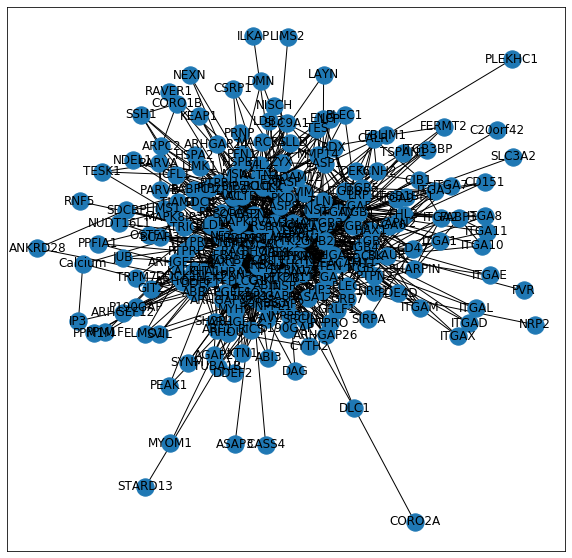

In [31]:
# Plot adhesome network
plt.figure(figsize = (10,10))
nx.draw_networkx(adhesome_network, pos=None, arrows=True, with_labels=True)
plt.show()

# Cluster the network

In [32]:
# First test whether there is a community structure in this network
A = np.array(nx.adjacency_matrix(adhesome_network).todense())
nu.PET_test(A,0.05)

{'test_stat': 318521.4676519827, 'p_val': 0.0, 'reject': True}

In [33]:
# Network connected?
nx.is_connected(adhesome_network.to_undirected())

True

In [35]:
# Cluster network using Louvain community detection
partition_adhesome = community.best_partition(adhesome_network, resolution=1, random_state=6)
partition_adhesome_int = {key: str(val) for i,(key,val) in enumerate(partition_adhesome.items())}
nx.set_node_attributes(adhesome_network, partition_adhesome, 'modularity')
nx.set_node_attributes(adhesome_network, partition_adhesome_int, 'modularity_int')
print('Number of communities = '+str(len(set(partition_adhesome.values()))))
print('Modularity = '+str(community.modularity(partition_adhesome,adhesome_network)))

Number of communities = 6
Modularity = 0.2961126071404318


In [36]:
oi.output_networkx_graph_as_interactive_html(adhesome_network, filename="adhesome_network.html")

PosixPath('/home/louiscam/projects/gpcr/code/analysis_mar10/adhesome_network.html')

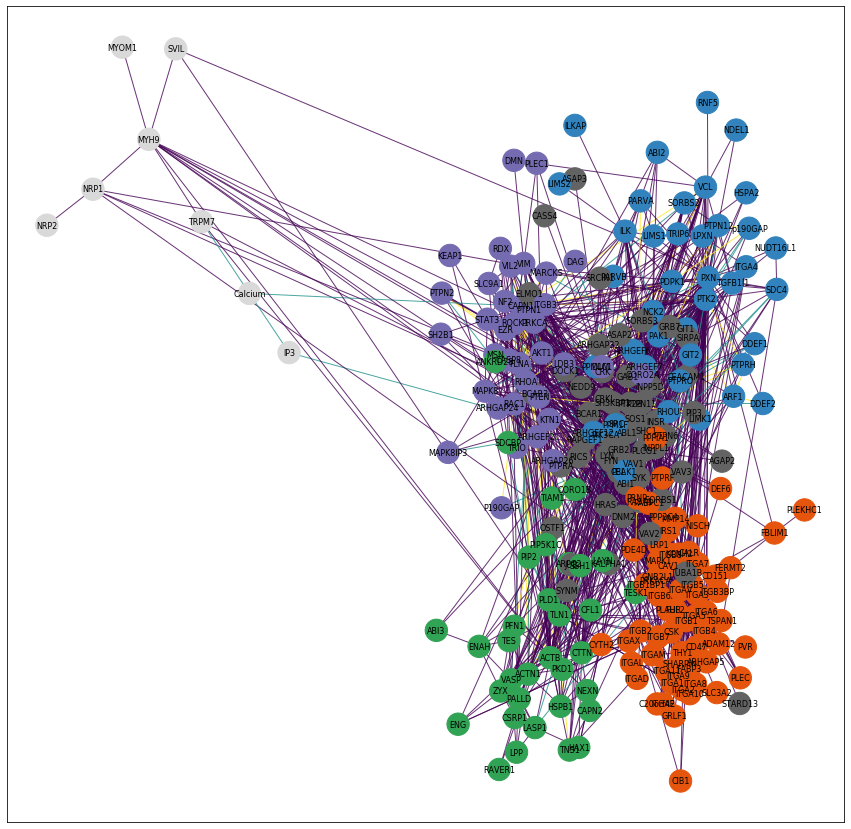

In [41]:
# Drawing
reload(nu)
plt.figure(figsize = (15,15))
size = float(len(set(partition_adhesome.values())))
pos = nu.community_layout(adhesome_network, partition_adhesome)
nx.draw_networkx_nodes(adhesome_network, pos, node_size=500, cmap=plt.cm.tab20c, 
                       node_color=list(nx.get_node_attributes(adhesome_network,'modularity').values()))
nx.draw_networkx_edges(adhesome_network, pos, alpha=0.8,
                       edge_color=nx.get_edge_attributes(adhesome_network,'TypeID').values(),
                       width=1)
#list(nx.get_edge_attributes(adhesome_network,'TypeID').values())
nx.draw_networkx_labels(adhesome_network, pos, font_size=8,font_family='sans-serif')
plt.show()

# Identify enrichment for activation/inhibition edges

In [42]:
# Number of communities
n_comm = len(set(partition_adhesome.values()))
print(n_comm)

6


In [43]:
# Store all subgraphs
subgraph_ls = []
for comm in range(n_comm):
    comm_nodes = [prot for prot in partition_adhesome.keys() if partition_adhesome[prot]==comm]
    subgraph = adhesome_network.subgraph(comm_nodes)
    subgraph_ls.append(subgraph)

In [44]:
# Number of nodes
nnodes_ls = []
for comm in range(n_comm):
    nnodes_ls.append(len(subgraph_ls[comm].nodes))

In [49]:
# Type of edges
nedges_ls, nact_ls, ninhib_ls, nplus_ls, nminus_ls = [], [], [], [], []
for comm in range(n_comm):
    comm_nodes = list(subgraph_ls[comm].nodes)
    df_comm = df_interactions[df_interactions['Source'].isin(comm_nodes) & df_interactions['Target'].isin(comm_nodes)]
    nedges_ls.append(len(df_comm))
    nact_ls.append(len(df_comm[df_comm['Type']=='activation']))
    ninhib_ls.append(len(df_comm[df_comm['Type']=='inhibition']))
    nplus_ls.append(len(df_comm[df_comm['Effect']=='+']))
    nminus_ls.append(len(df_comm[df_comm['Effect']=='_']))

In [50]:
# Create summary dataframe
network_summary = pd.DataFrame({'cluster': range(n_comm),
                                'size': nnodes_ls,
                                'edges': nedges_ls,
                                'activation': nact_ls,
                                'inhibition': ninhib_ls,
                                '+': nplus_ls,
                                '_': nminus_ls})
network_summary

,cluster,size,edges,activation,inhibition,+,_
0,0,40,239,12,16,14,20
1,1,63,336,6,2,56,9
2,2,34,154,16,6,16,6
3,3,37,226,40,24,51,29
4,4,54,844,100,36,143,48
5,5,8,14,4,0,4,0


In [51]:
network_summary.sum()

cluster         15
size           236
edges         1813
activation     178
inhibition      84
+              284
_              112
dtype: int64

In [344]:
df_comm[df_comm['Type']=='activation']

,Source,Target,Effect,Type,PMID,data_source,TypeID
999,ILK,PIP3,+,activation,10712922,adhesome.org,6
1106,PIP3,AKT1,+,activation,8939574,adhesome.org,6
225,ILK,AKT1,+,activation,9736715,adhesome.org,6


# Draft

In [ ]:
communities = nx.community.greedy_modularity_communities(adhesome_network)
partition_adhesome = {}
for i,c in enumerate(communities): 
    for name in c:
        partition_adhesome[name] = i
nx.set_node_attributes(adhesome_network, partition_adhesome, 'modularity')
print('Number of communities = '+str(len(set(partition_adhesome.values()))))
print('Modularity = '+str(community.modularity(partition_adhesome,adhesome_network)))

In [162]:
# Edge types in network
nx.to_pandas_edgelist(adhesome_network).Type.value_counts()

binding               840
activation            105
inhibition             54
phosphorylation        17
direct_interaction      9
dephosphorylation       2
colocalization          1
unknown                 1
gef                     1
enzymatic               1
Name: Type, dtype: int64

In [ ]:
plt.figure(figsize = (40,40))
nx.draw(adhesome_network, cmap=plt.cm.tab20c,
        node_color=list(nx.get_node_attributes(adhesome_network,'modularity').values()),
        edge_color=nx.get_edge_attributes(adhesome_network,'TypeID').values(),
        width=np.array(list(nx.get_edge_attributes(adhesome_network,'TypeID').values()))/4,
        with_labels=True)
plt.show()